In [59]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import NNSingleFeatureModel, tims_mse_loss, tim95_mse_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
from time import time
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

In [60]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')

def load_data(raw, dataset='', validation=False):
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/{key}.pkl')
    return raw[key]

In [61]:
def load_sub_model_with_config(train_config, model_configs, sub_model_key, X_count=0, force_recreate=False):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    model_config = model_configs[sub_model_key]
    f = f"{path}/{prefix}{sub_model_key}.pth"
    if os.path.exists(f) and not force_recreate:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        next_epoch = checkpoint['next_epoch']
    else:
        raise Exception('Model does not exist')
    return net, loss_func, optimizer, mean_losses, next_epoch

In [62]:
# # incase i need to save the current model in memory
# def save_model_with_config(train_config, sub_model_key, **kwargs):
#     path = train_config['model_path']
#     prefix = train_config['model_prefix']
#     f = f"{path}/{prefix}{sub_model_key}.pth"
#     torch.save(kwargs, f)

In [63]:
def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    model.eval()
    X_tensor = torch.from_numpy(X.to_numpy()).float()
    nn_results = model(X_tensor).detach().numpy()
    return nn_results

In [64]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [65]:
train_config = {
    'dataset' : 'sample2_', # '', 'sample_', 'secret_'
    'model_prefix' : "TRY_2_", 
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t5_models",
    'device' : 'cpu',
}

In [66]:
%%time
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=train_config['dataset'],validation=True)).dropna()
ref_test, X_test, y_test = get_ref_X_y(test_df)
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG', 'y_BSTAR']
y_test = y_test[y_cols]

Loading data to cache for: sample2_test
CPU times: user 1.39 s, sys: 4.11 s, total: 5.49 s
Wall time: 13 s


In [67]:
model_configs = {
    'y_INCLINATION': { 'feature_index': X_test.columns.get_loc('X_INCLINATION_1') },
    'y_ECCENTRICITY': { 'feature_index': X_test.columns.get_loc('X_ECCENTRICITY_1') },
    'y_MEAN_MOTION': { 'feature_index': X_test.columns.get_loc('X_MEAN_MOTION_1') },
    'y_RA_OF_ASC_NODE_REG': { 'feature_index': X_test.columns.get_loc('X_RA_OF_ASC_NODE_1') },
    'y_ARG_OF_PERICENTER_REG': { 'feature_index': X_test.columns.get_loc('X_ARG_OF_PERICENTER_1') },
    'y_REV_MA_REG': { 'feature_index': X_test.columns.get_loc('X_MEAN_ANOMALY_1') },
    'y_BSTAR': { 'feature_index': X_test.columns.get_loc('X_BSTAR_1') },
}

Loading existing model
y_INCLINATION
MSELoss()


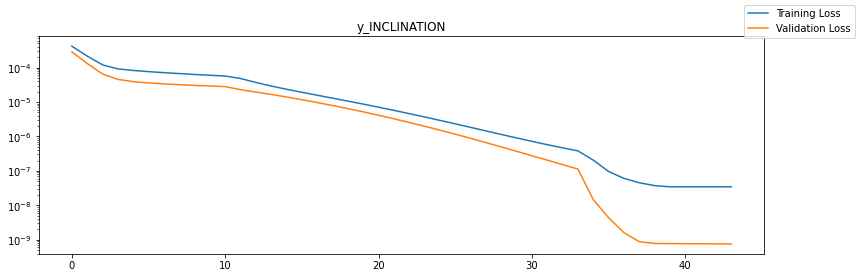

,train loss,validation loss
34,0.000000205387,0.000000014570
35,0.000000096035,0.000000004364
36,0.000000060675,0.000000001605
37,0.000000045281,0.000000000884
38,0.000000037312,0.000000000782
39,0.000000034529,0.000000000775
40,0.000000034526,0.000000000770
41,0.000000034565,0.000000000766
42,0.000000034521,0.000000000762
43,0.000000034560,0.000000000759


Epoch 44
    Test set MAE (L1) loss: 2.1712160593087292e-05
    Test set MSE (L2) loss: 1.164166450474973e-09
Loading existing model
y_ECCENTRICITY
MSELoss()


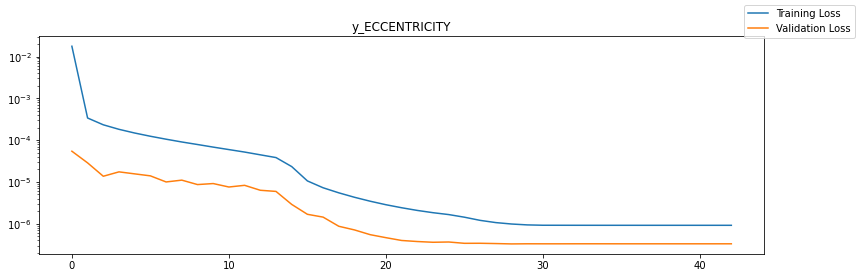

,train loss,validation loss
33,0.000000914929,0.000000330305
34,0.000000914558,0.000000330176
35,0.000000914479,0.000000329848
36,0.000000914382,0.000000329907
37,0.000000914054,0.000000329895
38,0.000000914338,0.000000329890
39,0.000000914296,0.000000329884
40,0.000000914023,0.000000329875
41,0.000000914307,0.000000329845
42,0.000000914210,0.000000329905


Epoch 43
    Test set MAE (L1) loss: 0.0003759243475630046
    Test set MSE (L2) loss: 8.403713036738288e-07
Loading existing model
y_MEAN_MOTION
MSELoss()


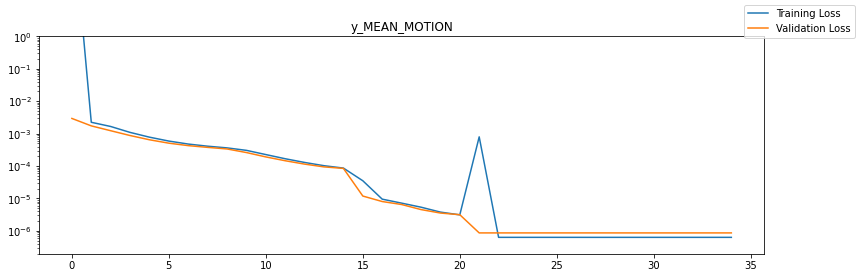

,train loss,validation loss
25,0.000000631816,0.000000865598
26,0.000000631864,0.000000865362
27,0.000000631129,0.000000865908
28,0.000000631549,0.000000865354
29,0.000000631740,0.000000865534
30,0.000000631656,0.000000865481
31,0.000000631627,0.000000865416
32,0.000000631730,0.000000865534
33,0.000000631739,0.000000865601
34,0.000000631778,0.000000865746


Epoch 35
    Test set MAE (L1) loss: 0.00019292059051122837
    Test set MSE (L2) loss: 8.571521046425673e-07
Loading existing model
y_RA_OF_ASC_NODE_REG
MSELoss()


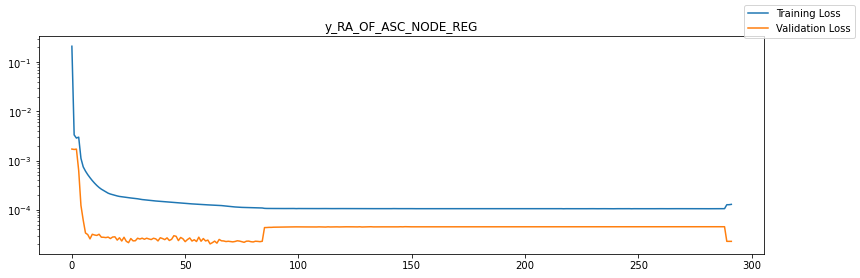

,train loss,validation loss
282,0.000105035059,0.000045219788
283,0.000105172125,0.000045212606
284,0.000105451360,0.000045221506
285,0.000105296680,0.000045220835
286,0.000105201858,0.000045221394
287,0.000105015474,0.000045217484
288,0.000105359311,0.000045220347
289,0.000126729167,0.000022805629
290,0.000126890627,0.000022785168
291,0.000128833747,0.000022815643


Epoch 292
    Test set MAE (L1) loss: 0.004119000098791491
    Test set MSE (L2) loss: 2.614077387904337e-05
Loading existing model
y_ARG_OF_PERICENTER_REG
MSELoss()


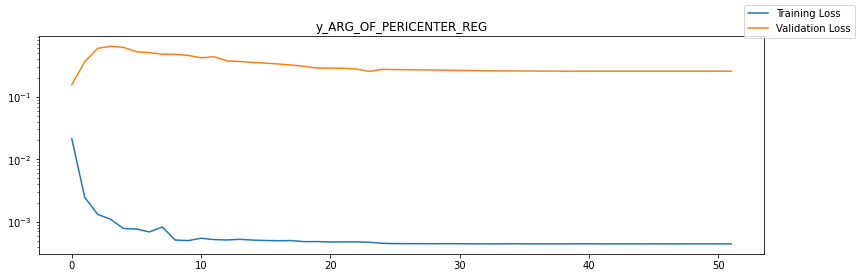

,train loss,validation loss
42,0.000442020019,0.257722874196
43,0.000442654660,0.257722138774
44,0.000441855336,0.257723934165
45,0.000443815115,0.257725537472
46,0.000442539248,0.257726670372
47,0.000441917659,0.257727160576
48,0.000442425189,0.257726650435
49,0.000442408761,0.257726577541
50,0.000442450742,0.257726001111
51,0.000442940806,0.257726093839


Epoch 52
    Test set MAE (L1) loss: 0.003849431072663481
    Test set MSE (L2) loss: 0.00010435130468183575
Loading existing model
y_REV_MA_REG
<function tims_mae_loss at 0x7f3a2f4285e0>


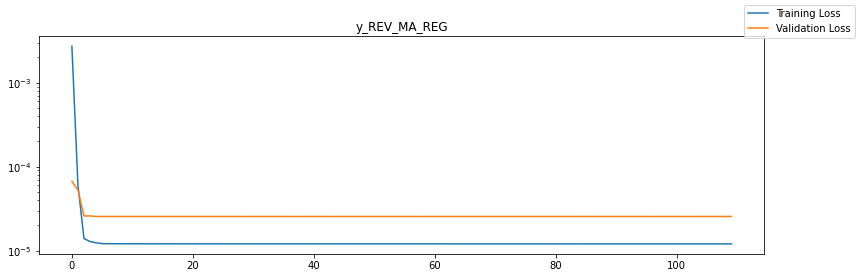

,train loss,validation loss
100,0.000012009112,0.000025497170
101,0.000012009192,0.000025492361
102,0.000012008557,0.000025492783
103,0.000012008655,0.000025488956
104,0.000012008264,0.000025499256
105,0.000012008354,0.000025493025
106,0.000012007877,0.000025494838
107,0.000012007863,0.000025499394
108,0.000012007634,0.000025494916
109,0.000012007648,0.000025502162


Epoch 110
    Test set MAE (L1) loss: 0.0010375536068293113
    Test set MSE (L2) loss: 1.1090099098597677e-05
Loading existing model
y_BSTAR
MSELoss()


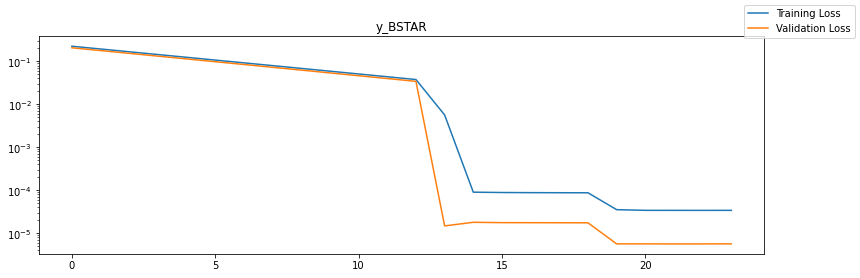

,train loss,validation loss
14,0.000090276277,0.000017977158
15,0.000088654878,0.000017646053
16,0.000088009670,0.000017597189
17,0.000087646517,0.000017536784
18,0.000087395123,0.000017467444
19,0.000035358277,0.000005651463
20,0.000034104913,0.000005652146
21,0.000034046270,0.000005643157
22,0.000034038302,0.000005646103
23,0.000034064731,0.000005662785


Epoch 24
    Test set MAE (L1) loss: 0.000431568405907036
    Test set MSE (L2) loss: 6.274123975548174e-06


0.100    0.001094799805
0.200    0.002200341797
0.300    0.003317309570
0.400    0.004475024414
0.500    0.005704858398
0.600    0.007090112305
0.700    0.008741259766
0.800    0.010941552734
0.900    0.014534838867
0.950    0.020979321289
0.975    0.031359051514
0.990    0.048939389648
0.999    0.101089684814
Name: error, dtype: float64

,y_INCLINATION,y_INCLINATION_pred,X_INCLINATION_1,y_ECCENTRICITY,y_ECCENTRICITY_pred,X_ECCENTRICITY_1,y_MEAN_MOTION,y_MEAN_MOTION_pred,X_MEAN_MOTION_1,y_RA_OF_ASC_NODE_REG,y_RA_OF_ASC_NODE_REG_pred,X_RA_OF_ASC_NODE_1,y_ARG_OF_PERICENTER_REG,y_ARG_OF_PERICENTER_REG_pred,X_ARG_OF_PERICENTER_1,y_REV_MA_REG,y_REV_MA_REG_pred,X_MEAN_ANOMALY_1,y_BSTAR,y_BSTAR_pred,X_BSTAR_1,error,epoch_diff
0,0.346124444444,0.346151828766,0.346109444444,0.2441064,0.243981897831,0.2439684,0.285024995429,0.285085886717,0.284982781714,0.615178055556,0.606423199177,0.622566666667,0.882899722222,0.885830402374,0.882507777778,0.145606620370,0.145607307553,0.105120277778,0.00659020,0.006807656493,0.00692640,0.009854541016,0.135120082855
1,0.346181666667,0.346237033606,0.346195000000,0.2443600,0.244438156486,0.2444256,0.285033877714,0.285109877586,0.285006766857,0.602100555556,0.593705713749,0.610089722222,0.884061944444,0.883298635483,0.883478611111,0.156706861111,0.156710147858,0.104065833333,0.00452420,0.004754745867,0.00487400,0.019932336426,0.145515520002
2,0.346195000000,0.346234053373,0.346191666667,0.2437784,0.243833094835,0.2438196,0.285093140571,0.285177558661,0.285074449143,0.568984722222,0.560217499733,0.576401388889,0.887070555556,0.886503458023,0.886425000000,0.145566493827,0.145569548011,0.101568055556,0.00257010,0.002518426161,0.00263790,0.014056591797,0.135113774287
3,0.346183333333,0.346229463816,0.346188888889,0.2437832,0.243758410215,0.2437496,0.285134531429,0.285210013390,0.285106883429,0.553012500000,0.545564770699,0.563279722222,0.888445277778,0.887521147728,0.887556944444,0.201108182099,0.201110124588,0.100518888889,0.00250030,0.002399447840,0.00251870,0.016608642578,0.187076012855
4,0.346188888889,0.346220582724,0.346183333333,0.2438176,0.243783548474,0.2437832,0.285174038857,0.285237610340,0.285134531429,0.537615833333,0.531346976757,0.553012500000,0.889783055556,0.889036655426,0.888445277778,0.301094648148,0.301095187664,0.099736388889,0.00244580,0.002380982740,0.00250030,0.011411926270,0.280607920002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263166,0.294408333333,0.294398725033,0.294416111111,0.0033292,0.004117707722,0.0042576,0.564744292571,0.552359104156,0.552256242286,-0.058554444444,0.005482152104,0.129252222222,0.528311388889,0.398721277714,0.300036111111,2.305243669753,2.299839258194,0.700573055556,0.00044483,0.000188201317,0.00030590,0.003456604004,1.832408758571
1263167,0.294400555556,0.294392824173,0.294416111111,0.0032776,0.004082622472,0.0042376,0.568122149714,0.552628874779,0.552526019429,-0.082295277778,-0.004772618413,0.122923611111,0.571551944444,0.418635904789,0.306106666667,2.515873592593,2.508928060532,0.694496666667,0.00042034,0.000201104936,0.00031888,0.002785205078,1.999327761429
1263168,0.294399444444,0.294393479824,0.294416111111,0.0032756,0.004055466969,0.0042088,0.569062436571,0.552957594395,0.552854692571,-0.087783333333,-0.011611327529,0.115691944444,0.583325000000,0.427750080824,0.313667500000,2.493520373457,2.486508846283,0.686928055556,0.00044343,0.000195970817,0.00031369,0.002148693848,1.981120154286
1263169,0.294396111111,0.294394373894,0.294416666667,0.0032292,0.003987531178,0.0041400,0.570633502857,0.553381502628,0.553278634286,-0.096021944444,-0.020408332348,0.106647777778,0.603306666667,0.433209568262,0.322167500000,2.482186966049,2.474975824356,0.678415833333,0.00044469,0.000214192201,0.00033193,0.000628259277,1.971523725714


count    1.263171000000e+06
mean     7.816374698902e-03
std      9.475239008975e-03
min      4.882812731921e-08
25%      2.757397460925e-03
50%      5.704858398445e-03
75%      9.734179687513e-03
max      2.991006835938e-01
Name: error, dtype: float64

In [69]:
# Create or load all new sub models here if needed.
# sample_idx = random.sample(list(X_test.index), 10000)
sample_idx = X_test.index
all_models = {}
display_data = []
# for sub_key in y_cols:
for sub_key in y_cols:
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key)
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)
    try:
        tl, vl = zip(*mean_losses)
        print(f'{sub_key}')
    except:
        print(f"No data for {sub_key}")
        continue

    fig,ax = plt.subplots(figsize=(13,4))
    print(loss_func)
    ax.plot(tl, label="Training Loss")
    ax.plot(vl, label="Validation Loss")
    ax.set_title(sub_key)
    ax.set_yscale('log')
    ax.set_ylim((ax.get_ylim()[0], min(1,ax.get_ylim()[1])))
    fig.legend()
    plt.show()
    display(pd.DataFrame(mean_losses, columns=['train loss','validation loss']).tail(10))

    trained_model = model
    X_sample = X_test.loc[sample_idx]
    y_sample = y_test.loc[sample_idx][[sub_key]]
    y_sample_pred = predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
    y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe
    print(f'Epoch {next_epoch}')
    print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
    print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')
    display_data.append(y_sample)
    display_data.append(y_sample_pred_df.add_suffix('_pred'))
    display_data.append(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1].values - y_sample_pred_df.values)
    print('==============================')
df = pd.concat(display_data, axis=1)
df['error'] = (np.abs(df.iloc[:,0]*360 - df.iloc[:,1]*360))%360
df['error'] = np.minimum(360-df.error,df.error)
display(df.error.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999]))
df['epoch_diff'] = X_sample.X_delta_EPOCH
display(df)
display(df.error.describe())

In [70]:
df = df.sort_values('error', ascending=False)
df = df.merge(ref_test, left_index=True, right_index=True)

In [71]:
df

,y_INCLINATION,y_INCLINATION_pred,X_INCLINATION_1,y_ECCENTRICITY,y_ECCENTRICITY_pred,X_ECCENTRICITY_1,y_MEAN_MOTION,y_MEAN_MOTION_pred,X_MEAN_MOTION_1,y_RA_OF_ASC_NODE_REG,y_RA_OF_ASC_NODE_REG_pred,X_RA_OF_ASC_NODE_1,y_ARG_OF_PERICENTER_REG,y_ARG_OF_PERICENTER_REG_pred,X_ARG_OF_PERICENTER_1,y_REV_MA_REG,y_REV_MA_REG_pred,X_MEAN_ANOMALY_1,y_BSTAR,y_BSTAR_pred,X_BSTAR_1,error,epoch_diff,__NORAD_CAT_ID_1,__GP_ID_1,__GP_ID_2,__EPOCH_1,__EPOCH_2
657125,0.368698888889,0.369529724121,0.369546666667,0.0529584,0.097358919680,0.0974976,0.314426321143,0.310244530439,0.310141653714,0.629687777778,0.641830444336,0.718204722222,0.617075833333,0.662186622620,0.680091944444,1.981996904321,1.979063630104,0.316142222222,0.10310000,0.081170447171,0.081288000,0.299100683594,1.818989600002,17358,46458848,46458852.0,1992-10-13 10:42:46.794815,1992-10-26 04:18:11.704896
657124,0.369018333333,0.369788229465,0.369793333333,0.0703512,0.103509709239,0.1036180,0.312765102857,0.309512138367,0.309409229714,0.660153333333,0.658516764641,0.732024166667,0.664893333333,0.670393943787,0.682247222222,1.614789314815,1.613113045692,0.310695277778,0.09235700,0.057693317533,0.057811000,0.277164038086,1.482776404284,17358,46458847,46458851.0,1992-10-11 10:34:02.598240,1992-10-21 19:40:25.767551
657366,0.369018333333,0.369783580303,0.369800555556,0.0703512,0.104973167181,0.1051120,0.312765102857,0.308883607388,0.308780717714,0.660153333333,0.669003725052,0.748395000000,0.664893333333,0.663252711296,0.683454444444,1.981455981481,1.979100108147,0.309337500000,0.09235700,0.048636406660,0.048754000,0.275485571289,1.820645622855,17358,18799964,46458851.0,1992-10-09 01:48:19.294848,1992-10-21 19:40:25.767551
657318,0.369018333333,0.369781702757,0.369798333333,0.0703512,0.104892887175,0.1050308,0.312765102857,0.308898478746,0.308795616000,0.660153333333,0.669562757015,0.747910277778,0.664893333333,0.663428187370,0.683520555556,1.970344870370,1.968005180359,0.309073333333,0.09235700,0.048694424331,0.048812000,0.274814184570,1.810406940000,17358,46458844,46458851.0,1992-10-09 03:31:31.650239,1992-10-21 19:40:25.767551
657190,0.369018333333,0.369772076607,0.369782222222,0.0703512,0.104041948915,0.1041632,0.312765102857,0.309232383966,0.309129464000,0.660153333333,0.660147428513,0.738962777778,0.664893333333,0.668746948242,0.683390555556,1.770344870370,1.768375277519,0.309144722222,0.09235700,0.054099403322,0.054217000,0.271350439453,1.626101038570,17358,18799966,46458851.0,1992-10-10 10:29:19.859424,1992-10-21 19:40:25.767551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614283,0.461142222222,0.461142241955,0.461137222222,0.0299000,0.030102375895,0.0301848,0.284395740571,0.284493267536,0.284390321143,0.970035555556,0.960211813450,0.987075000000,0.850187222222,0.853040814400,0.916860833333,1.279424611111,1.279405355453,0.082259166667,0.00030656,0.000114458773,0.000232340,0.000000048828,1.196477559998,15542,79358643,79486995.0,2010-09-02 08:01:00.919488,2010-09-10 17:01:30.547775
605944,0.461142222222,0.461142241955,0.461140555556,0.0306876,0.031012292951,0.0311032,0.284127299429,0.284228831530,0.284125881143,0.811323055556,0.802799344063,0.829698888889,0.055992500000,0.059479951859,0.125051111111,1.388279540124,1.388292074203,0.877010833333,0.00013060,0.000045585140,0.000163390,0.000000048828,1.290332790002,15542,72154195,72291471.0,2009-07-15 06:17:28.100255,2009-07-24 07:04:01.371648
1223585,0.549683888889,0.549683868885,0.549689444444,0.0045728,0.004277931061,0.0043876,0.328294603429,0.328385531902,0.328282621714,0.730032222222,0.730566740036,0.700968611111,0.718553333333,0.729672431946,0.814375555556,1.647571265432,1.647417783737,0.185627500000,0.00025784,0.000238285051,0.000355980,0.000000048828,1.497933497143,41071,105752525,105968265.0,2016-06-30 03:18:24.620544,2016-07-10 14:57:34.799616
1013464,0.547885555556,0.547885537148,0.547887777778,0.0694816,0.069159753621,0.0692608,0.348227731429,0.34832584857

In [47]:
esdf = df.copy()

In [48]:
ed = esdf.groupby(by='__GP_ID_1')['error'].describe()

In [49]:
ed.sort_values('mean', ascending=False).head(30).merge(ref_test[['__GP_ID_1','__NORAD_CAT_ID_1']].drop_duplicates(subset=['__GP_ID_1']), left_index=True, right_on='__GP_ID_1').head(30)

,count,mean,std,min,25%,50%,75%,max,__GP_ID_1,__NORAD_CAT_ID_1
935448,9.0,6.170856161579,2.070819781066,3.965522469596,3.998196468104,7.880540952682,7.915657719241,7.957970742235,98809954,14417
1653397,4.0,5.998080679249,2.306188921068,3.999875881060,4.001357056203,5.997374052733,7.994097675779,7.997698730471,102921825,38145
1263788,1.0,5.980109105904,NaN,5.980109105904,5.980109105904,5.980109105904,5.980109105904,5.980109105904,26048691,24975
42453,15.0,5.863521783586,2.062152472014,3.997957863504,3.999940027142,4.002147133369,7.992941579875,7.998291273881,50252406,5784
938555,9.0,5.733515087099,2.846046466954,0.128154613742,3.983283700047,7.855049322874,7.930733825926,7.956513936650,98843739,14417
42841,13.0,5.534263772452,2.022637705969,3.995546974838,3.998028927976,3.999535508388,7.990736634136,7.995483656700,50252405,5784
219578,3.0,5.385735787732,4.627762639216,0.042055826832,4.049498963719,8.056942100607,8.057575768182,8.058209435757,119504293,7128
227628,3.0,5.370075155557,4.621181149475,0.033995099900,4.035273159747,8.036551219594,8.038115183385,8.039679147175,115757673,7128
211126,3.0,5.368616743389,4.622772304748,0.030699201483,4.033632777855,8.036566354227,8.037575514341,8.038584674456,115783191,7128
763424,6.0,5.339292578505,2.065679579822,4.002306773026,4.006133847134,4.007702745237,7.006180502411,8.006759238294,50862931,13466


In [50]:
# another model overview
# Load all new sub models here if needed.
all_models = {}
for sub_key in model_configs.keys():
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key, len(X_test.columns), force_recreate=False)
    try:
        tl, vl = zip(*mean_losses)
    except:
        print(f"No data for {sub_key}")
        continue
    print(f'{sub_key}\nEpoch:      {next_epoch}\nLast TLoss: {tl[-1]}\nLast VLoss: {vl[-1]}')
    print(f'Loss func:  {loss_func}\nOptimizer:  {optimizer}')
    print('---------')
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)

Loading existing model
y_INCLINATION
Epoch:      44
Last TLoss: 3.455963329329612e-08
Last VLoss: 7.591381967486655e-10
Loss func:  MSELoss()
Optimizer:  AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-09
    weight_decay: 0.057
)
---------
Loading existing model
y_ECCENTRICITY
Epoch:      43
Last TLoss: 9.142103758652778e-07
Last VLoss: 3.299049993188419e-07
Loss func:  MSELoss()
Optimizer:  AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-08
    weight_decay: 0.05
)
---------
Loading existing model
y_MEAN_MOTION
Epoch:      35
Last TLoss: 6.317781523864659e-07
Last VLoss: 8.657459881687503e-07
Loss func:  MSELoss()
Optimizer:  AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0.01
)
---------
Loading existing model
y_RA_OF_ASC_NODE_REG
Epoch:      292
Last TLoss: 0.00012883374662040463
Last VLoss: 2.2815643205831293e-05
Loss func:

In [51]:
# nums = ((90 * 360 * np.abs((df.y_REV_MA_REG - df.y_REV_MA_REG_pred)))%360)
# nums = np.minimum(nums, np.abs(360-nums))
# nums.name = "MEAN_ANOMALY_ERROR"
# nums.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999])

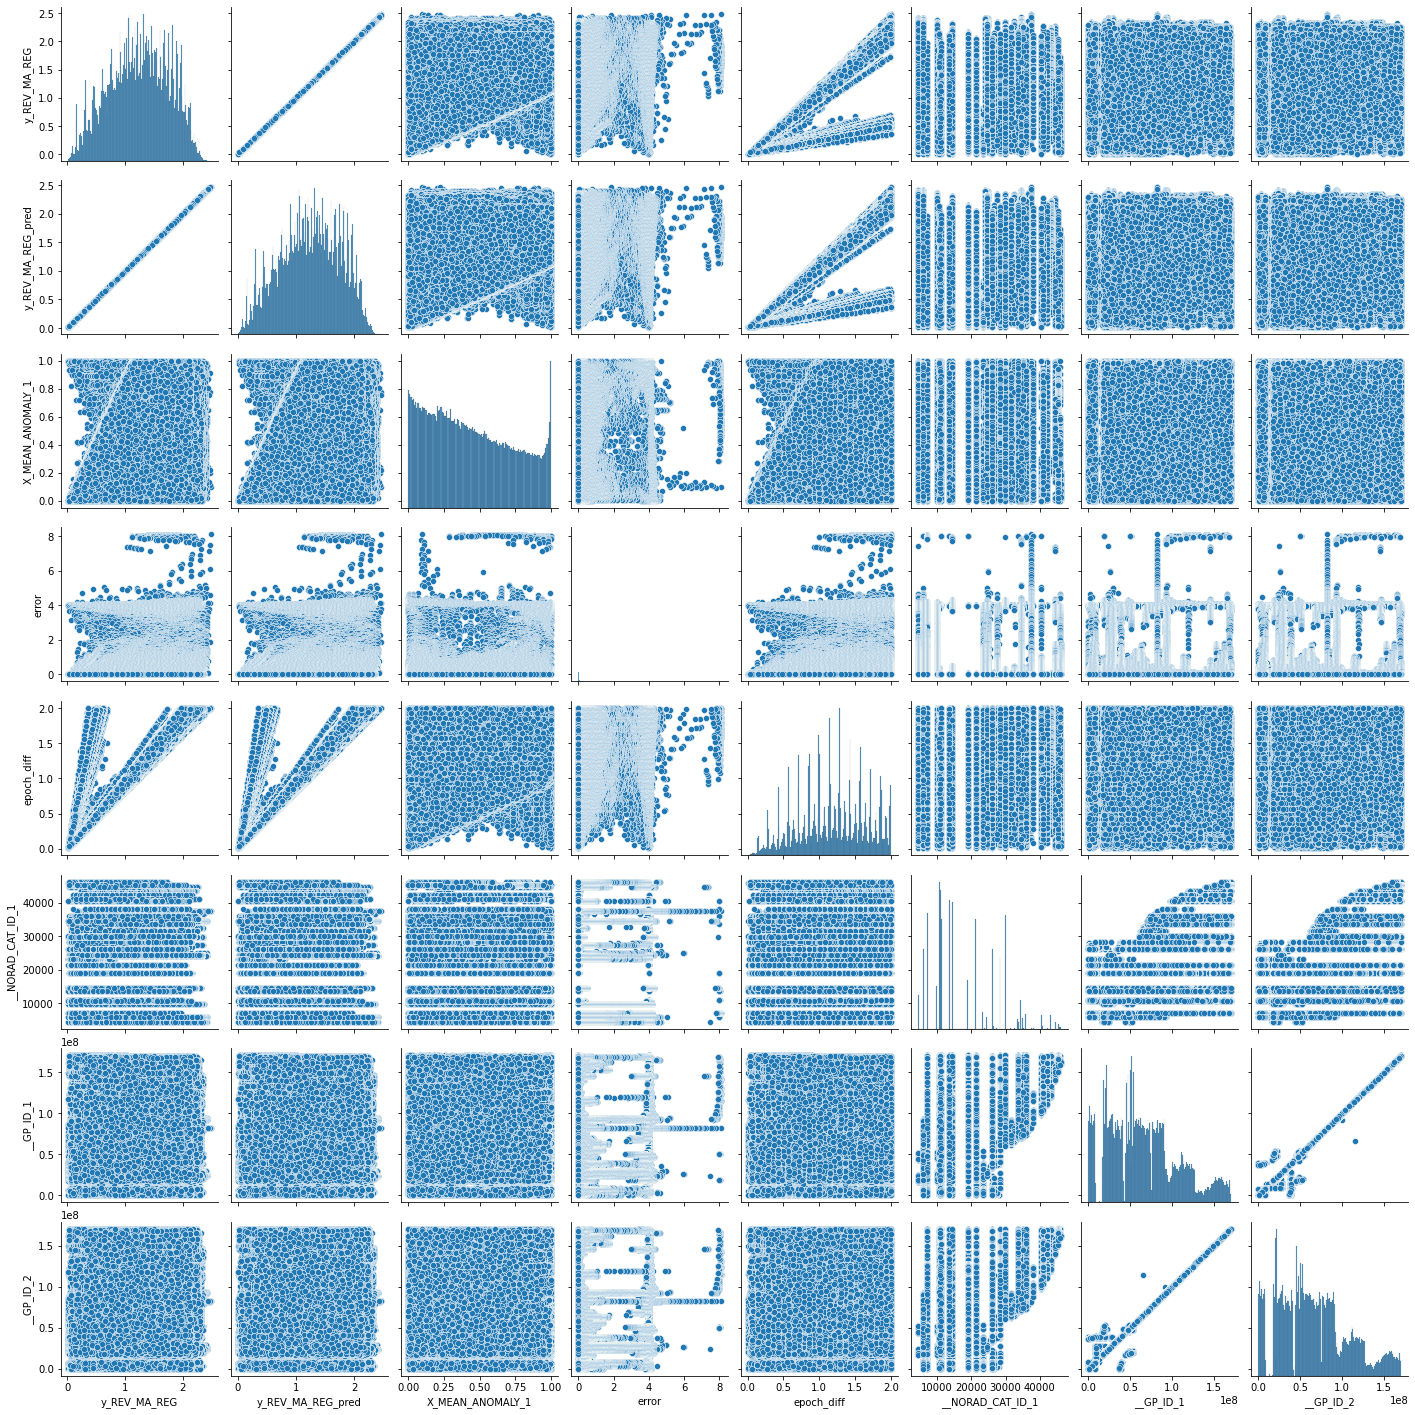

In [52]:
import seaborn

seaborn.pairplot(df)

AdamW optimizer
Decrease learning rate slowly over time
Decrease weight decay if both training and validation are decreasing similarly